### 1. Libraries

In [22]:
import os
import numpy as np
import IPython.display as ipd
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 2. Define the Paths

In [23]:
DATASET_ROOT = r"C:\Users\DT\Documents\Homework\16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

### 3. Mel Spectrograms

In [24]:
def parse_dataset_mels(dataset_paths, n_mels=64, n_fft=1024, hop_length=512):
    X = []
    y = []

    for index, dataset in enumerate(dataset_paths):
        print(f"[+] Parsing {dataset} data...")

        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)

            # Mel-Spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=wav,
                sr=sr,
                n_mels=n_mels,
                n_fft=n_fft,
                hop_length=hop_length
            )

            # Covert to dB
            mel_db = librosa.power_to_db(mel_spec, ref=np.max)

            X.append(mel_db)
            y.append(index)

    return X, y



X, y = parse_dataset_mels([BENJAMIN_DATA, JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])
print(f"Total parsed data {len(X)}")


[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Julia_Gillard data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Nelson_Mandela data...
Total parsed data 7501


### 4. Slip data (Training, Testing)

In [25]:
X_train, X_test, y_train, y_test = train_test_split( 
    X,
    y,
    test_size=0.05,
    random_state=42,
    stratify=y)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Length of training subset: ", len(X_train))
print("Lenght of testing subset: ", len(X_test))

Length of training subset:  7125
Lenght of testing subset:  376


### 5. Define Model (MLP)

In [27]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

num_classes = len(set(y))

network = models.Sequential()
network.add(layers.Dense(150, activation='relu', input_shape=(X_train_flat.shape[1],)))
network.add(layers.Dense(68, activation='relu'))
network.add(layers.Dense(num_classes, activation='softmax'))

network.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 6. Fit Model

In [28]:
network.fit(
    X_train_flat,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_flat, y_test)
)

Epoch 1/20
223/223 [==============================] - 1s 3ms/step - loss: 5.2738 - accuracy: 0.5521 - val_loss: 1.4905 - val_accuracy: 0.6941
Epoch 2/20
223/223 [==============================] - 1s 2ms/step - loss: 0.6244 - accuracy: 0.8212 - val_loss: 0.5805 - val_accuracy: 0.8245
Epoch 3/20
223/223 [==============================] - 1s 2ms/step - loss: 0.3760 - accuracy: 0.8835 - val_loss: 0.6351 - val_accuracy: 0.7952
Epoch 4/20
223/223 [==============================] - 1s 2ms/step - loss: 0.4956 - accuracy: 0.8692 - val_loss: 0.2193 - val_accuracy: 0.9255
Epoch 5/20
223/223 [==============================] - 1s 3ms/step - loss: 0.4344 - accuracy: 0.8935 - val_loss: 0.6274 - val_accuracy: 0.8431
Epoch 6/20
223/223 [==============================] - 1s 2ms/step - loss: 0.2373 - accuracy: 0.9354 - val_loss: 0.0744 - val_accuracy: 0.9787
Epoch 7/20
223/223 [==============================] - 1s 2ms/step - loss: 0.3556 - accuracy: 0.9148 - val_loss: 0.1143 - val_accuracy: 0.9628
Epoch 

### 7. Metrics

In [29]:
X_test_flat = X_test.reshape(len(X_test), -1)

y_pred_proba = network.predict(X_test_flat)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Accuracy: {acc}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

12/12 [==============================] - 0s 1ms/step
Accuracy: 0.976063829787234
F1-score: 0.976122207254309
AUC: 0.9996917584659322


### 8. Confusion Matrix

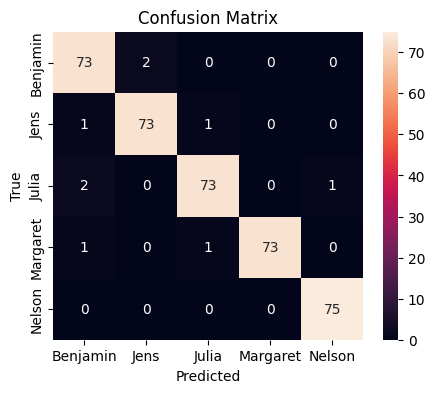

In [30]:
labels = ["Benjamin", "Jens", "Julia", "Margaret", "Nelson"]

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()